<a href="https://colab.research.google.com/github/JNishimura/Deep-Learning-Recommenders/blob/main/GMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann
!pip install ipywidgets
import os
import pprint
import tempfile
import scipy as sp

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import math
import heapq
import matplotlib.pyplot as plt
def load_rating_file_as_list(filename):
    rating_list = []
    
    with open(filename, "r") as f:
        line = f.readline()
        
        while line and line != "":
            arr = line.split("\t")
            user, item = int(arr[0]), int(arr[1])
            rating_list.append([user, item])
            line = f.readline()
    
    return rating_list

def load_negative_file(filename):
    negative_list = []
    
    with open(filename, "r") as f:
        line = f.readline()
        
        while line and line != "":
            arr = line.split("\t")
            negatives = []
            
            for x in arr[1:]:
                negatives.append(int(x))
            
            negative_list.append(negatives)
            
            line = f.readline()
    
    return negative_list

def load_rating_file_as_matrix(filename):
    num_users, num_items = 0, 0
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            u, i = int(arr[0]), int(arr[1])
            num_users = max(num_users, u)
            num_items = max(num_items, i)
            line = f.readline()
    
    mat = sp.sparse.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
            if (rating > 0):
                mat[user, item] = 1.0
            line = f.readline()    
    return mat


train = load_rating_file_as_matrix('ml-1m.train.rating')
test_ratings = load_rating_file_as_list('ml-1m.test.rating')
test_negatives = load_negative_file('ml-1m.test.negative')

num_users, num_items = train.shape
print('Loaded Data. # Users:', num_users, '# Items:', num_items, '# Train:', train.nnz, '# Test:', len(test_ratings))

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 394.7MB 29kB/s 
     |████████████████████████████████| 3.7MB 3.8MB/s 
     |████████████████████████████████| 11.1MB 1.3MB/s 
Loaded Data. # Users: 6040 # Items: 3706 # Train: 994169 # Test: 6040


In [ ]:
import tensorboard as tb

In [ ]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while train.get((u, j)):
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

def evaluate(model, testPosRatings, testNegRatings, N):
    hits = []
    ndcgs = []
    for i in range(len(testPosRatings)):
        hit, ncdg = evaluate_one(model, testPosRatings[i], testNegRatings[i], N)
        hits.append(hit)
        ndcgs.append(ncdg)
        
    return np.array(hits).mean(), np.array(ndcgs).mean()

def evaluate_one(model, posRating, negRatings, N):
    user = posRating[0]
    movie = posRating[1]
    negRatings.append(movie)

    user_input = np.full(len(negRatings), user)

    predictions = model.predict([user_input, np.array(negRatings)], batch_size = 100)

  # associate item with predictions
    items = {}
    for i in range(len(predictions)):
        items[negRatings[i]] = predictions[i]
    negRatings.pop()

    rankedList = heapq.nlargest(N, items, items.get)
    ndcg = evaluateNDCG(rankedList, movie)
    hit = hitRate(rankedList, movie)

    return hit, ndcg

def evaluateNDCG(ranked_list, target_item):
    for i in range(len(ranked_list)):
        if ranked_list[i] == target_item:
            return math.log(2) / math.log(i + 2)
  
    return 0

def hitRate(ranked_list, target_item):
    for rank in ranked_list:
        if target_item == rank:
            return 1
    return 0

In [ ]:
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Reshape, Multiply, Flatten, Lambda, Concatenate, Layer, Dropout, Average
from keras import initializers, regularizers
import sys
from keras.optimizers import Adam
from keras.regularizers import *

In [ ]:
def get_GMFmodel(num_users, num_items, latent_dim):
  user_input = Input(shape = (1,), dtype = 'int32', name = 'user')
  item_input = Input(shape = (1,), dtype = 'int32', name = 'item')

  user_embedding = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)
  item_embedding = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)

  user_latent = Flatten()(user_embedding(user_input))
  item_latent = Flatten()(item_embedding(item_input))

  prediction_vec = Multiply()([user_latent, item_latent])

  prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(prediction_vec)

  return Model(inputs=[user_input, item_input], outputs=prediction)


modelGMF =  get_GMFmodel(num_users, num_items, 32)
modelGMF.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
NUM_EPOCHS = 10
best_hr = 0
best_ncdg = 0
best_epoch = -1


hit_rate, ncdg = evaluate(modelGMF, test_ratings, test_negatives, N = 10)
print('Initial Model', 'Hit Rate:', hit_rate, 'NCDG:', ncdg)

for epoch in range(1, NUM_EPOCHS + 1):
    user_input, item_input, labels = get_train_instances(train, num_negatives = 4)

    hist = modelGMF.fit([np.array(user_input), np.array(item_input)],
                      np.array(labels),
                      batch_size = 256, epochs = 1)

    hit_rate, ncdg = evaluate(modelGMF, test_ratings, test_negatives, N = 10)
    print('Epoch', epoch, 'Hit Rate:', hit_rate, 'NCDG:', ncdg)

    if hit_rate > best_hr:
        best_hr, best_ncdg, best_iter = hit_rate, ncdg, epoch

print("Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ncdg))

Initial Model Hit Rate: 0.09387417218543047 NCDG: 0.04267152235933905
19418/19418 [==============================] - 71s 4ms/step - loss: 0.3555 - binary_accuracy: 0.8445
Epoch 1 Hit Rate: 0.6102649006622517 NCDG: 0.3499508661759382
19418/19418 [==============================] - 71s 4ms/step - loss: 0.2697 - binary_accuracy: 0.8833
Epoch 2 Hit Rate: 0.6493377483443709 NCDG: 0.37930734902452834
19418/19418 [==============================] - 79s 4ms/step - loss: 0.2595 - binary_accuracy: 0.8880
Epoch 3 Hit Rate: 0.6625827814569536 NCDG: 0.3886154521646449
19418/19418 [==============================] - 69s 4ms/step - loss: 0.2553 - binary_accuracy: 0.8902
Epoch 4 Hit Rate: 0.6687086092715232 NCDG: 0.39830294573222824
19418/19418 [==============================] - 70s 4ms/step - loss: 0.2531 - binary_accuracy: 0.8912
Epoch 5 Hit Rate: 0.6751655629139073 NCDG: 0.3955019495212004
19418/19418 [==============================] - 70s 4ms/step - loss: 0.2517 - binary_accuracy: 0.8921
Epoch 6 Hit 

In [ ]:

Initial Model Hit Rate: 0.0956953642384106 NCDG: 0.043118849395635296
19418/19418 [==============================] - 59s 3ms/step - loss: 0.3731 - binary_accuracy: 0.8348
Epoch 1 Hit Rate: 0.5140728476821192 NCDG: 0.2830173639422832
19418/19418 [==============================] - 58s 3ms/step - loss: 0.3220 - binary_accuracy: 0.8535
Epoch 2 Hit Rate: 0.5223509933774835 NCDG: 0.2917348787210077
19418/19418 [==============================] - 56s 3ms/step - loss: 0.3199 - binary_accuracy: 0.8541
Epoch 3 Hit Rate: 0.5258278145695364 NCDG: 0.29378874774078423
19418/19418 [==============================] - 55s 3ms/step - loss: 0.3194 - binary_accuracy: 0.8542
Epoch 4 Hit Rate: 0.5294701986754967 NCDG: 0.2939602872015906
19418/19418 [==============================] - 56s 3ms/step - loss: 0.3178 - binary_accuracy: 0.8552
Epoch 5 Hit Rate: 0.53658940397351 NCDG: 0.2974924525806346
19418/19418 [==============================] - 56s 3ms/step - loss: 0.3100 - binary_accuracy: 0.8597
Epoch 6 Hit Rate: 0.5559602649006623 NCDG: 0.3086740701144606
19418/19418 [==============================] - 56s 3ms/step - loss: 0.3086 - binary_accuracy: 0.8606
Epoch 7 Hit Rate: 0.5673841059602649 NCDG: 0.3121740741044407
19418/19418 [==============================] - 54s 3ms/step - loss: 0.3084 - binary_accuracy: 0.8608
Epoch 8 Hit Rate: 0.5650662251655629 NCDG: 0.3112465998340405
19418/19418 [==============================] - 56s 3ms/step - loss: 0.3082 - binary_accuracy: 0.8611
Epoch 9 Hit Rate: 0.547682119205298 NCDG: 0.30381032405777175
19418/19418 [==============================] - 58s 3ms/step - loss: 0.3088 - binary_accuracy: 0.8610
Epoch 10 Hit Rate: 0.5663907284768211 NCDG: 0.31383539269689537
Best Iteration 7:  HR = 0.5674, NDCG = 0.3122. 

Initial Model Hit Rate: 0.09834437086092715 NCDG: 0.04599118081471922
19418/19418 [==============================] - 64s 3ms/step - loss: 0.3631 - binary_accuracy: 0.8408
Epoch 1 Hit Rate: 0.5902317880794702 NCDG: 0.3324936120701025
19418/19418 [==============================] - 63s 3ms/step - loss: 0.2841 - binary_accuracy: 0.8754
Epoch 2 Hit Rate: 0.6120860927152317 NCDG: 0.35115707858546513
19418/19418 [==============================] - 63s 3ms/step - loss: 0.2788 - binary_accuracy: 0.8778
Epoch 3 Hit Rate: 0.6225165562913907 NCDG: 0.35838337624240935
19418/19418 [==============================] - 63s 3ms/step - loss: 0.2772 - binary_accuracy: 0.8783
Epoch 4 Hit Rate: 0.6225165562913907 NCDG: 0.3537673895077624
19418/19418 [==============================] - 63s 3ms/step - loss: 0.2750 - binary_accuracy: 0.8796
Epoch 5 Hit Rate: 0.626158940397351 NCDG: 0.3583648369148386
19418/19418 [==============================] - 65s 3ms/step - loss: 0.2713 - binary_accuracy: 0.8817
Epoch 6 Hit Rate: 0.6451986754966887 NCDG: 0.37406899265854765
19418/19418 [==============================] - 64s 3ms/step - loss: 0.2680 - binary_accuracy: 0.8834
Epoch 7 Hit Rate: 0.6427152317880794 NCDG: 0.3733443553915798
19418/19418 [==============================] - 66s 3ms/step - loss: 0.2654 - binary_accuracy: 0.8848
Epoch 8 Hit Rate: 0.6471854304635761 NCDG: 0.3757405798616541
19418/19418 [==============================] - 66s 3ms/step - loss: 0.2637 - binary_accuracy: 0.8858
Epoch 9 Hit Rate: 0.6508278145695364 NCDG: 0.38048420049997606
19418/19418 [==============================] - 63s 3ms/step - loss: 0.2630 - binary_accuracy: 0.8863
Epoch 10 Hit Rate: 0.6518211920529802 NCDG: 0.3792384664056038
Best Iteration 10:  HR = 0.6518, NDCG = 0.3792. 

Initial Model Hit Rate: 0.09387417218543047 NCDG: 0.04267152235933905
19418/19418 [==============================] - 71s 4ms/step - loss: 0.3555 - binary_accuracy: 0.8445
Epoch 1 Hit Rate: 0.6102649006622517 NCDG: 0.3499508661759382
19418/19418 [==============================] - 71s 4ms/step - loss: 0.2697 - binary_accuracy: 0.8833
Epoch 2 Hit Rate: 0.6493377483443709 NCDG: 0.37930734902452834
19418/19418 [==============================] - 79s 4ms/step - loss: 0.2595 - binary_accuracy: 0.8880
Epoch 3 Hit Rate: 0.6625827814569536 NCDG: 0.3886154521646449
19418/19418 [==============================] - 69s 4ms/step - loss: 0.2553 - binary_accuracy: 0.8902
Epoch 4 Hit Rate: 0.6687086092715232 NCDG: 0.39830294573222824
19418/19418 [==============================] - 70s 4ms/step - loss: 0.2531 - binary_accuracy: 0.8912
Epoch 5 Hit Rate: 0.6751655629139073 NCDG: 0.3955019495212004
19418/19418 [==============================] - 70s 4ms/step - loss: 0.2517 - binary_accuracy: 0.8921
Epoch 6 Hit Rate: 0.6793046357615894 NCDG: 0.402687046030812
19418/19418 [==============================] - 72s 4ms/step - loss: 0.2503 - binary_accuracy: 0.8928
Epoch 7 Hit Rate: 0.6834437086092715 NCDG: 0.4047930111431965
19418/19418 [==============================] - 71s 4ms/step - loss: 0.2496 - binary_accuracy: 0.8932
Epoch 8 Hit Rate: 0.6639072847682119 NCDG: 0.39234977382775005
19418/19418 [==============================] - 71s 4ms/step - loss: 0.2490 - binary_accuracy: 0.8934
Epoch 9 Hit Rate: 0.6766556291390728 NCDG: 0.4010418695360625
19418/19418 [==============================] - 71s 4ms/step - loss: 0.2487 - binary_accuracy: 0.8937
Epoch 10 Hit Rate: 0.6837748344370861 NCDG: 0.40683168403730763
Best Iteration 10:  HR = 0.6838, NDCG = 0.4068. 

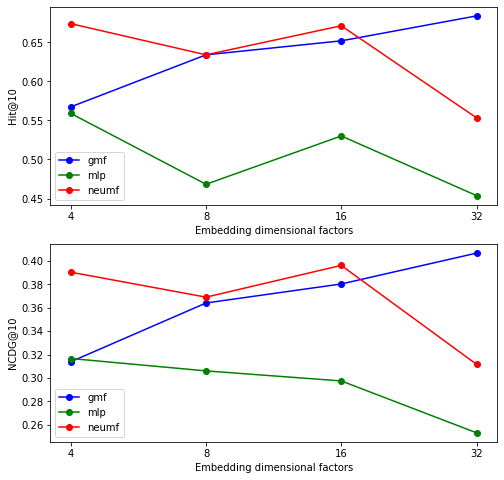

In [ ]:
import matplotlib.pyplot as plt
x = [4,8,16,32]
yGMF_hit = [0.5673, .6339, .6518, .6837]
yGMF_ncdg = [.3138, .3641, .3804, .4068]
yMLP_hit = [.559, .4683, .5301, .4538]
yMLP_ncdg = [.3166, .306, .2974, .253]
yneumf_hit = [.6738, .6339, .6711, .5533]
yneumf_ncdg = [.3905, .3691, .3963, .3116]
fig = plt.figure(1, figsize=(8,8))
ax1 = fig.add_subplot(211)
ax1.axes.set_xlabel('Embedding dimensional factors')
ax1.axes.set_ylabel('Hit@10')
ax1.axes.set_xticks([1,2,3,4])
ax1.axes.set_xticklabels(x)

ax1.plot([1,2,3,4], yGMF_hit, 'bo-')
ax1.plot([1,2,3,4], yMLP_hit, 'go-')
ax1.plot([1,2,3,4], yneumf_hit, 'ro-')
ax1.legend(['gmf', 'mlp', 'neumf'])

ax2 = fig.add_subplot(212)
ax2.axes.set_xlabel('Embedding dimensional factors')
ax2.axes.set_ylabel('NCDG@10')
ax2.axes.set_xticks([1,2,3,4])
ax2.axes.set_xticklabels(x)
ax2.plot([1,2,3,4], yGMF_ncdg, 'bo-')
ax2.plot([1,2,3,4], yMLP_ncdg, 'go-')
ax2.plot([1,2,3,4], yneumf_ncdg, 'ro-')
ax2.legend(['gmf', 'mlp', 'neumf'])



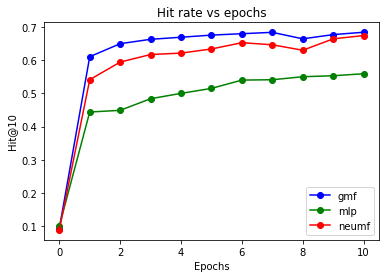

In [ ]:
x=range(0,11)
x = list(x)
y_gmfhit = [0.0938,
0.6102,
0.6493,
0.6625,
0.6687,
0.6751,
0.6793,
0.6834,
0.6639,
0.6766,
0.6837]

y_gmfncdg=[0.042,
0.3499,
0.3793,
0.3886,
0.3983,
0.3955,
0.4026,
0.4047,
0.3923,
0.401,
0.4068]

y_gmfloss = [0.5555,
0.2697,
0.2595,
0.2553,
0.2531,
0.2517,
0.2503,
0.2496,
0.249,
0.2487,
0.2481]

y_mlphit=[0.101,
0.444,
0.449,
0.484,
0.5,
0.515,
0.5399,
0.541,
0.55,
0.553,
0.559]

y_mlpncdg=[0.043,
0.2496,
0.2506,
0.2681,
0.2749,
0.2872,
0.3,
0.303,
0.308,
0.314,
0.3166]

y_mlploss=[0.5867,
0.3554,
0.3505,
0.3351,
0.3266,
0.3211,
0.3159,
0.3118,
0.3086,
0.3066,
0.3051]

y_mfhit=[0.0897,
0.5412,
0.594,
0.6168,
0.621,
0.6334,
0.6523,
0.646,
0.6296,
0.6639,
0.6738]

y_mfncdg=[.044,
.3291,
.3537,
0.361,
0.354,
0.368,
0.367,
0.361,
0.3684,
0.3688,
0.3691]

y_mfloss=[0.5808,
0.2967,
0.2819,
0.2765,
0.2729,
0.2691,
0.2656,
0.264,
0.2627,
0.2615,
0.2608]

plt.title('Hit rate vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Hit@10')
plt.plot(x, y_gmfhit, 'bo-')
plt.plot(x, y_mlphit, 'go-')
plt.plot(x, y_mfhit, 'ro-')
plt.legend(['gmf', 'mlp', 'neumf'])





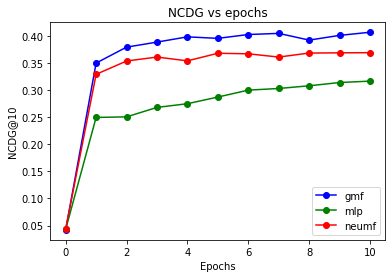

In [ ]:
plt.title('NCDG vs epochs')
plt.xlabel('Epochs')
plt.ylabel('NCDG@10')
plt.plot(x, y_gmfncdg, 'bo-')
plt.plot(x, y_mlpncdg, 'go-')
plt.plot(x, y_mfncdg, 'ro-')
plt.legend(['gmf', 'mlp', 'neumf'])

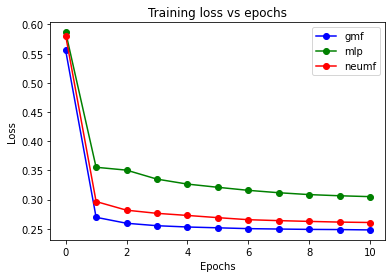

In [ ]:
plt.title('Training loss vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x, y_gmfloss, 'bo-')
plt.plot(x, y_mlploss, 'go-')
plt.plot(x, y_mfloss, 'ro-')
plt.legend(['gmf', 'mlp', 'neumf'])

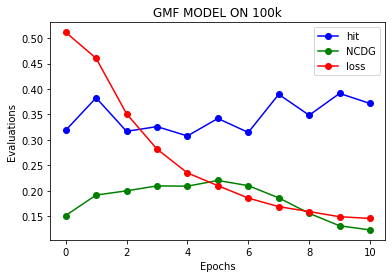

In [ ]:
gmf100khit = [0.3187,
0.38264,
0.3168,
0.326,
0.3077,
0.342,
0.3146,
0.3895,
0.3484,
0.3913,
0.3715]

gmf100kncdg = [0.1513,
0.1915,
0.1998,
0.2095,
0.209,
0.2202,
0.21,
0.186,
0.1556,
0.1311,
0.123]

gmf100kloss = [0.5115,
0.4603,
0.3513,
0.2819,
0.235,
0.21,
0.1856,
0.1687,
0.1591,
0.1489,
0.1456]

plt.title('GMF MODEL ON 100k')
plt.xlabel('Epochs')
plt.ylabel('Evaluations')
plt.plot(x, gmf100khit, 'bo-')
plt.plot(x, gmf100kncdg, 'go-')
plt.plot(x, gmf100kloss, 'ro-')
plt.legend(['hit', 'NCDG', 'loss'])